In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Use a pretty font for plots
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

### EOM to be solved:
$m\ddot{u}+c\dot{u}+ku=p(t)$

Given initial conditions
$u(0)=0$, $\dot{u}(0) = 0$

Subjected to the force:
$p(t) = 
\begin{cases}
p(t) = 8 \sin{(\pi t/0.4)} &\text{for } t\leq 1.2 \text{ sec} \\ 
p(t) = 0 &\text{for } t>1.2 \text{ sec}
\end{cases} \text{ kips}$ 

Our system has:
- $k=5$ kips/in
- $T_n=1$ sec
- $\zeta=0.05$

(0.0, 4.0)

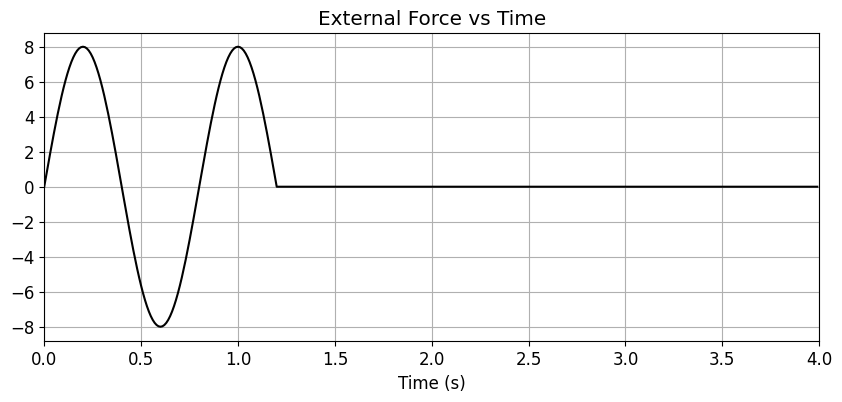

In [2]:
# Plot the force:
T_max = 4.0  # Max time for solutions and plotting

t = np.arange(0, T_max, 0.01)
p = 8.0 * np.sin(np.pi*t/0.4) * (t <= 1.2)

plt.figure(figsize=(10, 4))
plt.plot(t, p, 'k', label='External Force (p)')
plt.title('External Force vs Time')
plt.grid()
plt.xlabel('Time (s)')
plt.xlim(0, T_max)


(1)
Let's derive the analyitical solution first. For $t<t_d$, we have harmonic forcing, and therefore, the solution will look like:

$u(t) = e^{-\zeta \omega_n t}(A\cos{(\omega_d t)}+B\sin{(\omega_d t)}) + C \sin{(\omega t)} + D \cos{(\omega t)}$

In the textbook, we can find equations for $C$ and $D$:

$C = \dfrac{p_o}{k} \dfrac{1 - (\omega / \omega_n )^2}{(1-(\omega / \omega_n)^2)^2 + (2 \zeta (\omega / \omega_n))^2} $

$D = \dfrac{p_o}{k} \dfrac{- 2 \zeta \omega / \omega_n}{(1-(\omega / \omega_n)^2)^2 + (2 \zeta (\omega / \omega_n))^2} $

So, we have 1/2 of the solution. The remaining part of the problem is funding $A$ and $B$ using the initial conditions:

$u(0) = 0 \text{ plug into } u(t) \text{ above to find:}\\
\Rightarrow A + D = 0 \Rightarrow A = -D$

And for the velocities, we need an expression for $\dot{u}(t)$, so take one derivative:

$\dot{u}(t) = -\zeta \omega_n e^{-\zeta \omega_n t} (A \cos{(\omega_d t)} + B \sin{(\omega_d t)}) + \\
\hspace{1cm} e^{-\zeta \omega_n t}(-A \omega_d \sin{(\omega_d t)} + B \omega_d \cos{(\omega_d t)}) + \\
\hspace{1cm} C\omega \cos{(\omega t)} - D \omega \sin{(\omega t)}
$

Evaluate at $t=0$:

$\dot{u}(0) = 0 \\
\Rightarrow -\zeta \omega_n A + B \omega_d + C \omega = 0 \\
\Rightarrow B \omega_d = \zeta \omega_n A - C \omega \\ 
\Rightarrow B = \zeta A \dfrac{\omega_n}{\omega_d} - C \dfrac{\omega}{\omega_d}
$

So, we have the full solution for $t\leq t_d$. 
For $t>t_d$, we'll use free vibration response with initial conditions given by our solution for $t\leq t_d$ evaluated at $t=t_d$.

In [3]:
# (1) Analytical solution

def analytical_solution(m, k, c, po, w, t):
    '''
    Analytical solution for the equation of motion of a single degree of freedom system, subjected to zero initial conditions
    and the force indicated in the problem.
    '''

    wn = np.sqrt(k/m)  # Natural frequency
    zeta = c / (2 * m * wn)  # Damping ratio
    wd = wn * np.sqrt(1 - zeta**2)  # Damped natural frequency
    
    C = (po/k) * (1 - (w/wn)**2) / ((1 - (w/wn)**2)**2 + (2*zeta*(w/wn))**2)
    D = (po/k) * (-2*zeta*(w/wn)) / ((1 - (w/wn)**2)**2 + (2*zeta*(w/wn))**2)
    A = -D
    B = zeta * A * (wn/wd) - C * (w/wd)

    if t < 1.2:  # Forced vibration response
        u_t = np.exp(-zeta*wn*t) * (A * np.cos(wd*t) + B * np.sin(wd*t)) + C * np.sin(w*t) + D * np.cos(w*t)
    
    else:  # Free vibration response after force stops
        t_d = 1.2  # Time when force stops
        u_td = np.exp(-zeta*wn*t_d) * (A * np.cos(wd*t_d) + B * np.sin(wd*t_d)) + C * np.sin(w*t_d) + D * np.cos(w*t_d)
        udot_td = np.exp(-zeta*wn*t_d) * ( 
            -zeta*wn*(A * np.cos(wd*t_d) + B * np.sin(wd*t_d)) + 
            (-A*wd * np.sin(wd*t_d) + B*wd * np.cos(wd*t_d))
        ) + C*w * np.cos(w*t_d) - D*w * np.sin(w*t_d)

        A_free = u_td
        B_free = (udot_td + zeta*wn*u_td) / wd
        
        u_t = np.exp(-zeta*wn*(t - t_d)) * (A_free * np.cos(wd*(t - t_d)) + B_free * np.sin(wd*(t - t_d)))
    
    return u_t

# Implementation of the central difference scheme
def central_difference(m, k, c, uo, udot0, dt, p):
    '''
    Central difference scheme for solving the equation of motion of a single degree of freedom system.
    Parameters:
        m : mass
        k : stiffness
        c : damping coefficient
        uo : initial displacement
        udot0 : initial velocity
        dt : time step
        p : external force array (given as np array or list)
    Returns:
        u : displacement array
        v : velocity array
        a : acceleration array
    '''
    # Initial settings
    n = len(p)  # number of time steps
    u = np.zeros(n)  # displacement array
    v = np.zeros(n)  # velocity array
    a = np.zeros(n)  # acceleration array
    u[0] = uo
    v[0] = udot0

    # Initial acceleration
    a[0] = (p[0] - c * v[0] - k * u[0]) / m

    # Central difference coefficients
    a_c = m / dt**2 - c / (2 * dt)  # effective mass term
    b_c = k - 2 * m / dt**2  # effective stiffness term

    # Effective stiffness (from rearranging the equation)
    k_hat = m * (1 / dt ** 2) + c * (1 / (2 * dt))

    # For first step, need u[-1] using Taylor expansion
    u_minus1 = u[0] - dt * v[0] + (dt ** 2) / 2 * a[0]

    # Time-stepping loop
    for i in range(1, n):
        # Right-hand side of the equation (effective force)
        if i == 1:
            # First step uses u_minus1
            rhs = p[i] - a_c * u_minus1 - b_c * u[i-1]
        else:
            # Subsequent steps use u[i-2]
            rhs = p[i] - a_c * u[i-2] - b_c * u[i-1]
        
        # Solve for displacement at current time step
        u[i] = rhs / k_hat
        
        # Calculate velocity and acceleration using central difference
        if i == 1:
            v[i] = (u[i] - u_minus1) / (2 * dt)
            a[i] = (u[i] - 2 * u[i-1] + u_minus1) / (dt ** 2)
        else:
            v[i] = (u[i] - u[i-2]) / (2 * dt)
            a[i] = (u[i] - 2 * u[i-1] + u[i-2]) / (dt ** 2)
    
    print("Central Difference Method Completed")

    return u, v, a


# Using the same architecture as for central difference, implement the Newmark-beta method with beta = 1/4 and gamma = 1/2 as default values
def newmark_beta(m, k, c, uo, udot0, dt, p, beta=1/4, gamma=1/2):
    '''
    Newmark-beta method for solving the equation of motion of a single degree of freedom system.
    Parameters:
        m : mass
        k : stiffness
        c : damping coefficient
        uo : initial displacement
        udot0 : initial velocity
        dt : time step
        p : external force array (given as np array or list)
        beta : Newmark-beta parameter (default is 1/4)
        gamma : Newmark-gamma parameter (default is 1/2)
    Returns:
        u : displacement array
        v : velocity array
        a : acceleration array
    '''
    n = len(p)  # number of time steps
    u = np.zeros(n)  # displacement array
    v = np.zeros(n)  # velocity array
    a = np.zeros(n)  # acceleration array
    u[0] = uo
    v[0] = udot0

    # Initial acceleration
    a[0] = (p[0] - c * v[0] - k * u[0]) / m

    # Newmark-beta effective coefficients (Chopra Eq. 16.5.6, 16.5.7)
    a0 = 1.0 / (beta * dt ** 2)
    a1 = gamma / (beta * dt)
    a2 = 1.0 / (beta * dt)
    a3 = 1.0 / (2 * beta) - 1
    a4 = gamma / beta - 1
    a5 = dt * (gamma / (2 * beta) - 1)

    k_hat = k + a0 * m + a1 * c

    # Time-stepping loop
    for i in range(1, n):
        # Effective force (Chopra Eq. 16.5.8)
        p_hat = p[i] + m * (a0 * u[i - 1] + a2 * v[i - 1] + a3 * a[i - 1]) \
                      + c * (a1 * u[i - 1] + a4 * v[i - 1] + a5 * a[i - 1])
        u[i] = p_hat / k_hat
        a[i] = a0 * (u[i] - u[i - 1]) - a2 * v[i - 1] - a3 * a[i - 1]
        v[i] = v[i - 1] + dt * ((1 - gamma) * a[i - 1] + gamma * a[i])

    print("Newmark-Beta Method Completed")

    return u, v, a


Central Difference Method Completed
Newmark-Beta Method Completed


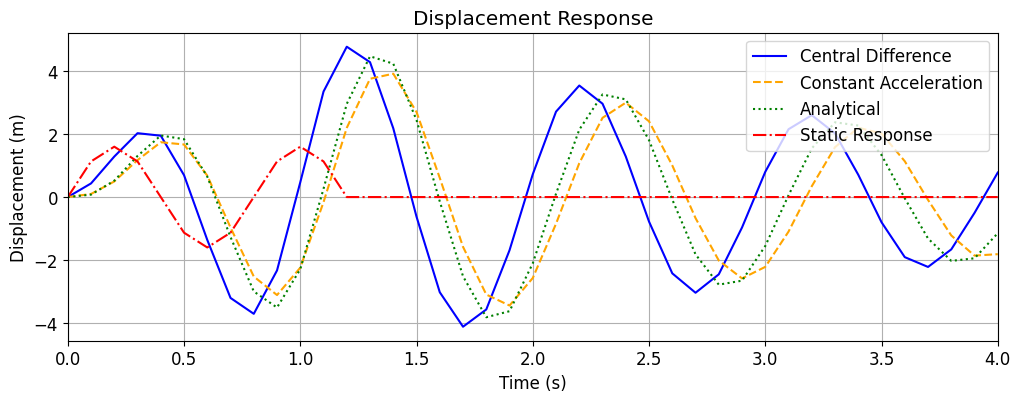

In [4]:
# Run the simulation using dt = 0.1

dt = 0.1 # time step
t = np.arange(0, T_max+dt, dt)  # time array
p = 8.0 * np.sin(np.pi*t/0.4) * (t <= 1.2) # external force

# System properties
k = 5.0 # kips/in
Tn = 1.0 # sec
zeta = 0.05 # damping ratio

# Additional calculations
wn = 2 * np.pi / Tn
m = k / wn**2
c = zeta * 2 * m * wn  # 5% damping

# Initial conditions
uo = 0.0  # initial displacement
udot0 = 0.0  # initial velocity

# Analytical solution
u_analytical = np.array([analytical_solution(m, k, c, 8.0, np.pi/0.4, ti) for ti in t])

# Central Difference Method
u_cd, v_cd, a_cd = central_difference(m, k, c, uo, udot0, dt, p)

# Newmark-Beta Method
u_nb, v_nb, a_nb = newmark_beta(m, k, c, uo, udot0, dt, p)

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t, u_cd, label='Central Difference', color='blue')
plt.plot(t, u_nb, label='Constant Acceleration', color='orange', linestyle='--')
plt.plot(t, u_analytical, label='Analytical', color='green', linestyle=':')
plt.plot(t, p/k, label='Static Response', color='red', linestyle='-.')  # Scaled force for reference
plt.title('Displacement Response')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.xlim(0, T_max)
plt.grid()


In [5]:
# Compile responses in a dataframe and show table (only displacement response)
data = []
data = pd.DataFrame(columns=['Time Step', 'Analytical', 'Central Diff.', 'Constant Accel.'])
data['Time Step'] = t
data['Analytical'] = u_analytical
data['Central Diff.'] = u_cd
data['Constant Accel.'] = u_nb

data

,Time Step,Analytical,Central Diff.,Constant Accel.
0,0.0,0.000000,0.000000,0.000000
1,0.1,0.077354,0.433043,0.098806
2,0.2,0.520380,1.286369,0.494947
3,0.3,1.305692,2.028386,1.173240
4,0.4,1.955443,1.948816,1.741316
5,0.5,1.839309,0.695123,1.669511
6,0.6,0.650287,-1.360677,0.681140
7,0.7,-1.268987,-3.203473,-0.967301
8,0.8,-2.997233,-3.707850,-2.523528
9,0.9,-3.508229,-2.329244,-3.111683


Central Difference Method Completed
Newmark-Beta Method Completed


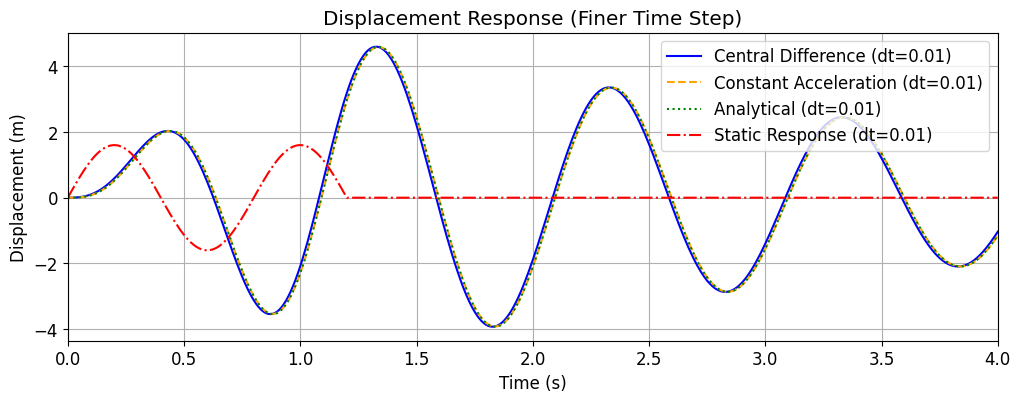

In [6]:
# We can test both implementations with smaller time steps to see if they converge to the analytical solution
dt_fine = 0.01 # finer time step
t_fine = np.arange(0, T_max+dt_fine, dt_fine)  # finer time array
p_fine = 8.0 * np.sin(np.pi*t_fine/0.4) * (t_fine <= 1.2) # external force for finer time step
# Solve with the three methods:
u_analytical_fine = np.array([analytical_solution(m, k, c, 8.0, np.pi/0.4, ti) for ti in t_fine])
u_cd_fine, v_cd_fine, a_cd_fine = central_difference(m, k, c, uo, udot0, dt_fine, p_fine)
u_nb_fine, v_nb_fine, a_nb_fine = newmark_beta(m, k, c, uo, udot0, dt_fine, p_fine)

# Plot results for finer time step
plt.figure(figsize=(12, 4))
plt.plot(t_fine, u_cd_fine, label='Central Difference (dt=0.01)', color='blue')
plt.plot(t_fine, u_nb_fine, label='Constant Acceleration (dt=0.01)', color='orange', linestyle='--')
plt.plot(t_fine, u_analytical_fine, label='Analytical (dt=0.01)', color='green', linestyle=':')
plt.plot(t_fine, p_fine/k, label='Static Response (dt=0.01)', color='red', linestyle='-.')  # Scaled force for reference
plt.title('Displacement Response (Finer Time Step)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.xlim(0, T_max)
plt.grid()
plt.show()

Central Difference Method Completed
Central Difference Method Completed
Central Difference Method Completed


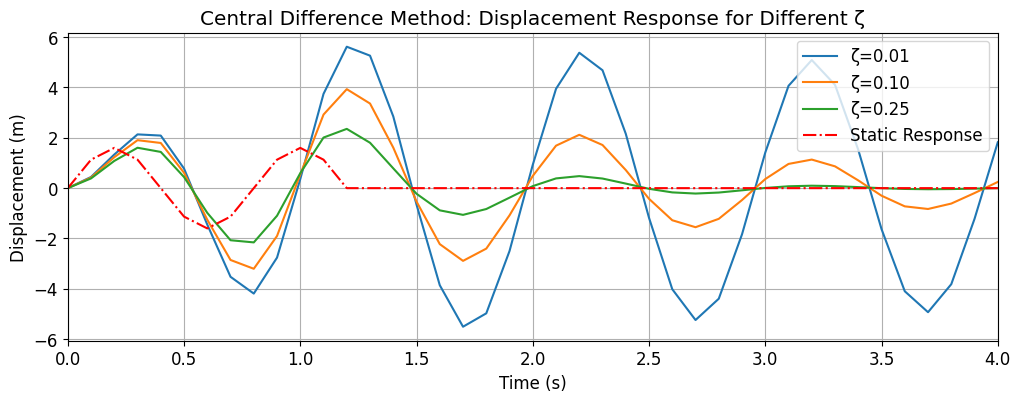

Newmark-Beta Method Completed
Newmark-Beta Method Completed
Newmark-Beta Method Completed


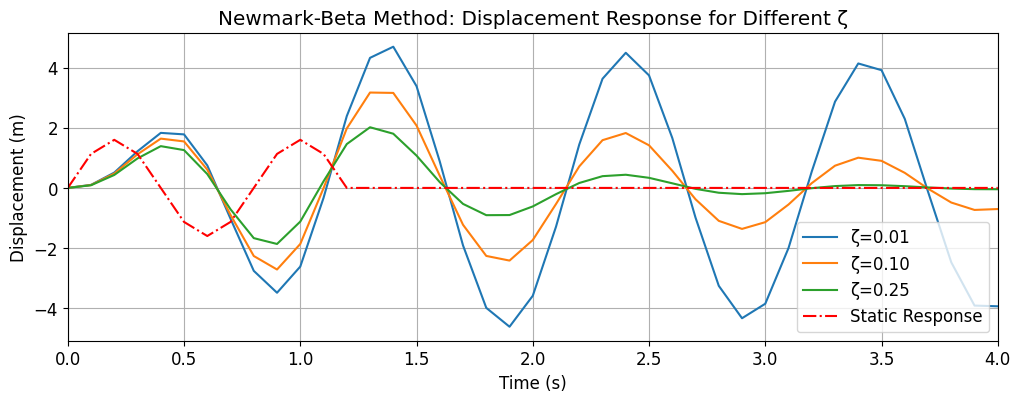

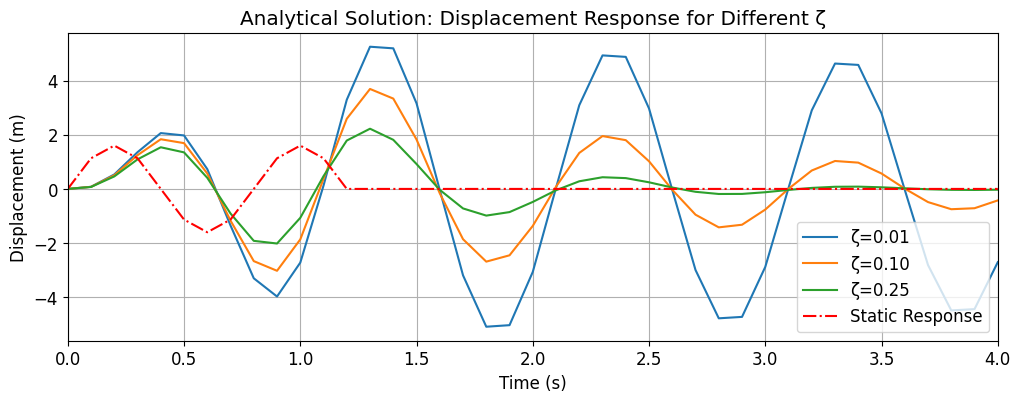

In [7]:
# Part b
# Now, we solve for different zeta values
zeta_values = [0.01, 0.1, 0.25]

# Plot all zeta values in the same axes for each method

plt.figure(figsize=(12, 4))
for zeta in zeta_values:
    c = zeta * 2 * m * wn
    u_cd_zeta = central_difference(m, k, c, uo, udot0, dt, p)[0]
    plt.plot(t, u_cd_zeta, label=f'ζ={zeta:.2f}')
plt.plot(t, p/k, label='Static Response', color='red', linestyle='-.')
plt.title('Central Difference Method: Displacement Response for Different ζ')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.xlim(0, T_max)
plt.grid()
plt.show()

plt.figure(figsize=(12, 4))
for zeta in zeta_values:
    c = zeta * 2 * m * wn
    u_nb_zeta = newmark_beta(m, k, c, uo, udot0, dt, p)[0]
    plt.plot(t, u_nb_zeta, label=f'ζ={zeta:.2f}')
plt.plot(t, p/k, label='Static Response', color='red', linestyle='-.')
plt.title('Newmark-Beta Method: Displacement Response for Different ζ')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.xlim(0, T_max)
plt.grid()
plt.show()

plt.figure(figsize=(12, 4))
for zeta in zeta_values:
    c = zeta * 2 * m * wn
    u_analytical_zeta = np.array([analytical_solution(m, k, c, 8.0, np.pi/0.4, ti) for ti in t])
    plt.plot(t, u_analytical_zeta, label=f'ζ={zeta:.2f}')
plt.plot(t, p/k, label='Static Response', color='red', linestyle='-.')
plt.title('Analytical Solution: Displacement Response for Different ζ')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.xlim(0, T_max)
plt.grid()
plt.show()


Damping directly affects the peak responses, and the time at which these happen (phase lag with respect to the peaks of the force.) The central difference method overpredicts the responses, especially for small values of damping. Damping helps our numerics! Makes the predictions more accurate and more stable.

Central Difference Method Completed
Central Difference Method Completed
Central Difference Method Completed


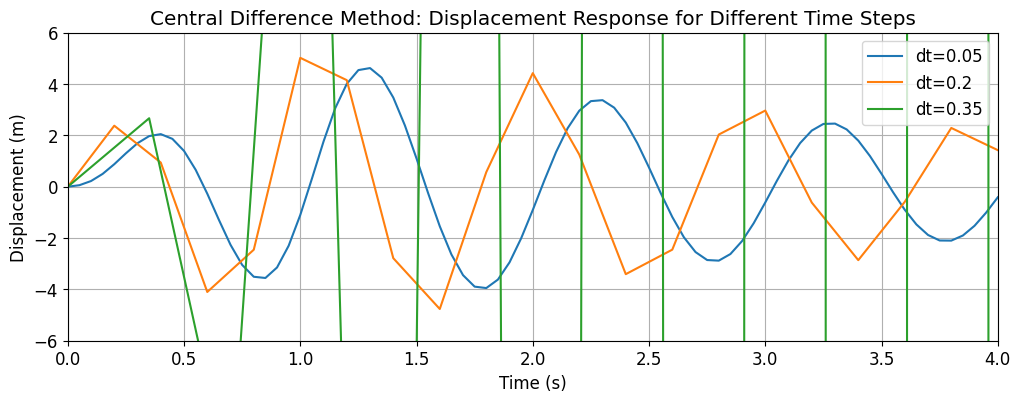

Newmark-Beta Method Completed
Newmark-Beta Method Completed
Newmark-Beta Method Completed


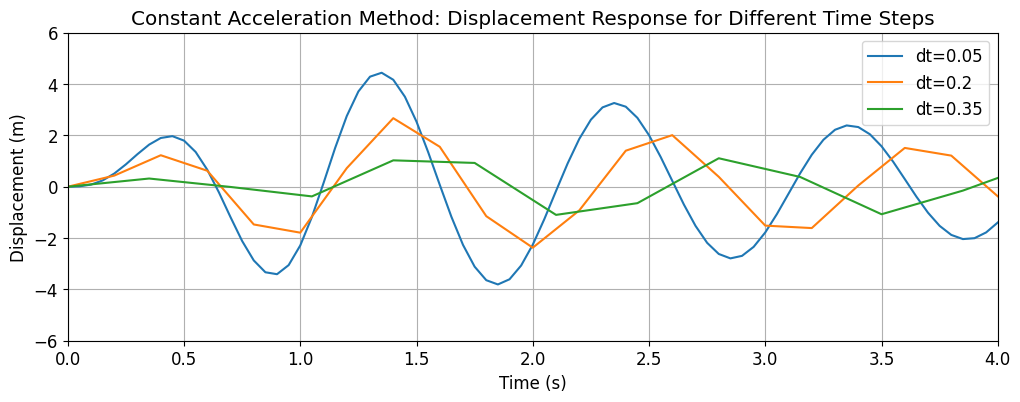

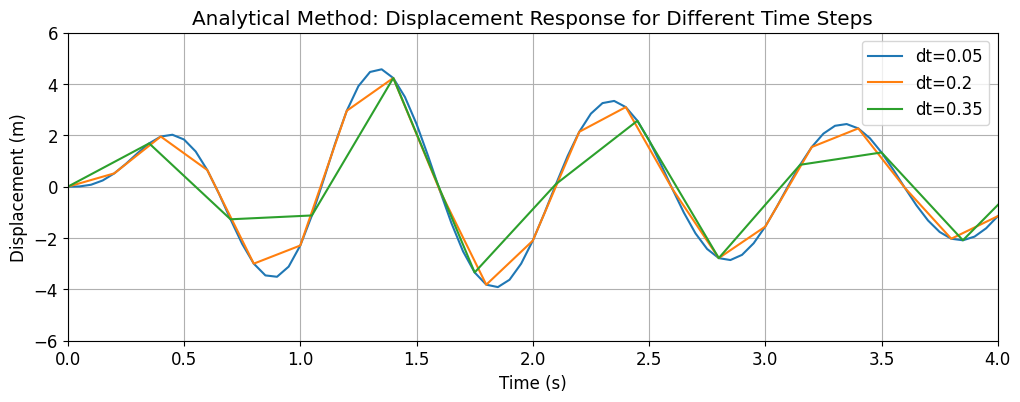

In [8]:
# Part c
# Now we do the same as above, but for different time steps, use zeta = 0.05
zeta = 0.05
c = zeta * 2 * m * wn
dt_values = [0.05, 0.2, 0.35]

for method_name, method_func in zip(
    ['Central Difference', 'Constant Acceleration', 'Analytical'],
    [central_difference, newmark_beta, lambda m, k, c, uo, udot0, dt, p: 
        np.array([analytical_solution(m, k, c, 8.0, np.pi/0.4, ti) for ti in np.arange(0, T_max+dt, dt)])]
):
    plt.figure(figsize=(12, 4))
    for dt in dt_values:
        t = np.arange(0, T_max+dt, dt)
        p = 8.0 * np.sin(np.pi*t/0.4) * (t <= 1.2)
        if method_name == 'Analytical':
            u = method_func(m, k, c, uo, udot0, dt, p)
        else:
            u = method_func(m, k, c, uo, udot0, dt, p)[0]
        plt.plot(t, u, label=f'dt={dt}')
    plt.title(f'{method_name} Method: Displacement Response for Different Time Steps')
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    plt.legend()
    plt.xlim(0, T_max)
    plt.ylim(-6.0, 6.0)
    plt.grid()
    plt.show()


Newmark's method, for the constant acceleration variant, is unconditionally stable, so regardless of the time-step we always get a response. However, the accuracy of the method is not great fot $\Delta t=0.35$. The central difference method provides reasonably accurate solutions for $dt=0.2$, in terms of peak responses, but it fails to give a proper solution for $\Delta t =0.35$ s, since the method is conditionally stable. We can verify, in fact that the condition for stability is $\Delta t / T_n \leq 1/\pi$, which for $\Delta t = 0.35$ sec it's not satisfied.